# Using Reddit's API for Predicting Comments

__[Slide Deck](https://docs.google.com/presentation/d/1Z3fYTsvtKYYh2dGTeKLHheFq0gRuY-X3BiD1SDbcZDA/edit#slide=id.p)__

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

In [1]:
import requests
import json
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [ ]:
URL = "http://www.reddit.com/hot.json"

In [ ]:
res = requests.get(URL, headers={"User-agent": "Sam Cressman Bot 0.1"})

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

In [ ]:
reddits = res.json()
reddits;

In [ ]:
reddits.keys();

In [ ]:
# EDA
reddits["data"].keys();

In [ ]:
# Keys: data, kind
reddits["data"]["after"];

In [ ]:
print(len(reddits['data']['children']));

#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/hot.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [ ]:
reddits["data"]["after"]

# id of the last post on the page 

In [ ]:
URL = "http://www.reddit.com/hot.json"

num_pages = 100

reddit_posts = []

after = None

for _ in range(num_pages):
    req_url = URL + "?after=" + after if after else URL
    res = requests.get(req_url, headers={"User-agent": "Sam Cressman Bot 0.1"})
    
    data = res.json()["data"]
    children = data["children"]
    after = data["after"]
    time.sleep(3)
    
    for j in range(len(children)):
        post = children[j]["data"]
        reddit_posts.append(post)    

In [ ]:
scrape_1 = pd.DataFrame(reddit_posts)

In [ ]:
# Created "time fetched" and "post age" features

scrape_1["time_fetched"] = pd.Timestamp.now()
scrape_1["time_fetched"].head();

In [ ]:
scrape_1["created_utc"] = pd.to_datetime(scrape_1["created_utc"], unit="s")
scrape_1["created_utc"].head();

In [ ]:
scrape_1["post_age"] = scrape_1["created_utc"] - scrape_1["time_fetched"]

In [ ]:
scrape_1["post_age"] = scrape_1["post_age"].dt.seconds / 3600

In [ ]:
scrape_1["post_age"].head();

#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [ ]:
median_comments = scrape_1["num_comments"].median()
median_comments

In [ ]:
scrape_1["above_median_comments"] = np.where(scrape_1["num_comments"] > median_comments, 1, 0)

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [ ]:
scrape_csv = scrape_1.to_csv("scrape.csv")

In [2]:
scrape_1_df = pd.read_csv("scrape.csv")

## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

I collected all JSON dictionary keys/values from 2500 posts in order to determine potential additional features before modeling.

### Exploratory Data Analysis (EDA)

In [5]:
scrape_1_df.columns;

In [136]:
# scrape_1_df.info();

In [7]:
scrape_1_df.head(5);

In [8]:
scrape_1_df["post_age"].mean()

13.356007888888897

Text(0,0.5,'Count of Posts')

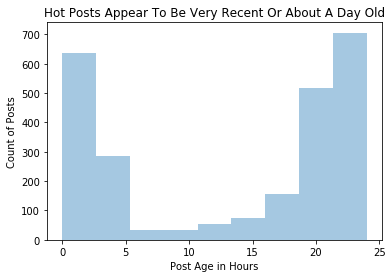

In [167]:
sns.distplot(scrape_1_df["post_age"], kde=False)
plt.title("Hot Posts Appear To Be Very Recent Or About A Day Old")
plt.xlabel("Post Age in Hours")
plt.ylabel("Count of Posts")

In [141]:
num_mean_comments_by_subreddit = scrape_1_df.groupby("subreddit").num_comments.mean().sort_values(ascending=False).head(10)
num_mean_comments_by_subreddit

num_mean_comments_by_subreddit = num_mean_comments_by_subreddit.sort_values(ascending=True);

Text(0.5,0,'Average Comments')

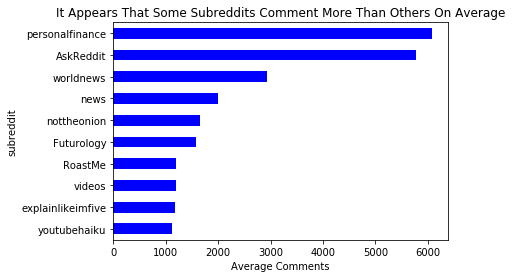

In [168]:
num_mean_comments_by_subreddit.plot.barh(color="blue")

plt.title("It Appears That Some Subreddits Comment More Than Others On Average")
plt.xlabel("Average Comments")

In [143]:
num_mean_ups_by_subreddit = scrape_1_df.groupby("subreddit").ups.mean().sort_values(ascending=False).head(10)
num_mean_ups_by_subreddit

num_mean_ups_by_subreddit = num_mean_comments_by_subreddit.sort_values(ascending=True);

Text(0,0.5,'Subreddit')

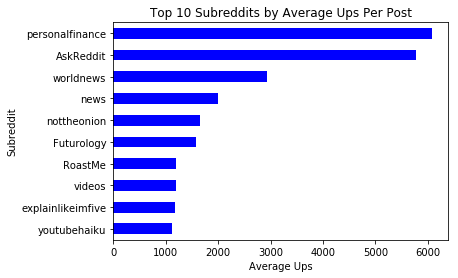

In [144]:
num_mean_ups_by_subreddit.plot.barh(color="blue")

plt.title("Top 10 Subreddits by Average Ups Per Post")
plt.xlabel("Average Ups")
plt.ylabel("Subreddit")

In [145]:
top_subreddit_posts_counts = scrape_1_df["subreddit"].value_counts().head(10)
top_subreddit_posts_counts

top_subreddit_posts_counts = top_subreddit_posts_counts.sort_values(ascending=True);

Text(0,0.5,'Subreddit')

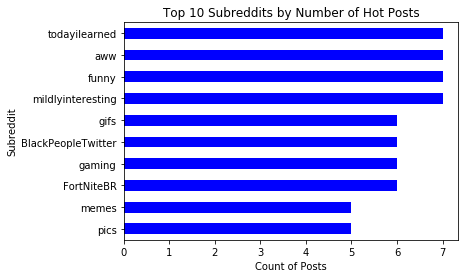

In [146]:
top_subreddit_posts_counts.plot.barh(color="blue")

plt.title("Top 10 Subreddits by Number of Hot Posts")
plt.xlabel("Count of Posts")
plt.ylabel("Subreddit")

Text(0,0.5,'Count of Subreddits')

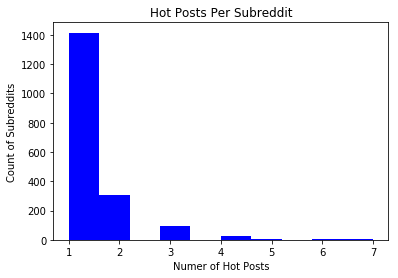

In [147]:
scrape_1_df["subreddit"].value_counts().plot(kind="hist", color="blue")
plt.title("Hot Posts Per Subreddit")
plt.xlabel("Numer of Hot Posts")
plt.ylabel("Count of Subreddits")

In [148]:
most_subreddit_subscribers = scrape_1_df.groupby("subreddit").subreddit_subscribers.max().sort_values(ascending=False).head(10)
most_subreddit_subscribers.head(20)

most_subreddit_subscribers = most_subreddit_subscribers.sort_values(ascending=True);

Text(0,0.5,'Subreddit')

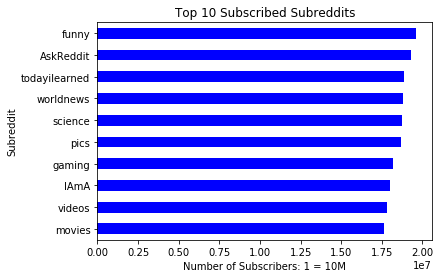

In [170]:
most_subreddit_subscribers.plot.barh(color="blue")

plt.title("Top 10 Subscribed Subreddits")
plt.xlabel("Number of Subscribers: 1 = 10M")
plt.ylabel("Subreddit")

In [151]:
mean_score_by_subreddit = scrape_1_df.groupby("subreddit").score.mean().sort_values(ascending=False).head(10)
mean_score_by_subreddit

mean_score_by_subreddit = mean_score_by_subreddit.sort_values(ascending=True);

Text(0,0.5,'Subreddit')

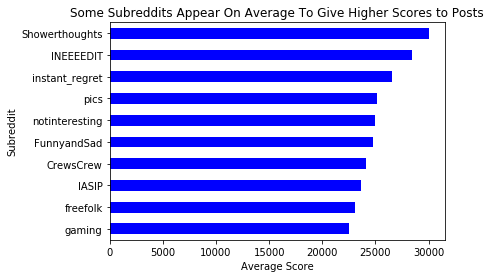

In [169]:
mean_score_by_subreddit.plot.barh(color="blue")

plt.title("Some Subreddits Appear On Average To Give Higher Scores to Posts")
plt.xlabel("Average Score")
plt.ylabel("Subreddit")

In [21]:
# Examining top 100 posts vs. top 2500 posts

top_100_scrape_1_df = scrape_1_df.head(100)
top_100_scrape_1_df;

In [22]:
top_100_scrape_1_df.num_comments.median(), scrape_1_df.num_comments.median()

(259.5, 26.0)

In [102]:
top_100_scrape_1_df.num_comments.mean(), scrape_1_df.num_comments.mean()

(707.75, 106.4152)

In [24]:
top_100_scrape_1_df.num_comments.max(), scrape_1_df.num_comments.max()

(10282, 10282)

In [25]:
top_100_scrape_1_df.num_comments.min(), scrape_1_df.num_comments.min()

(26, 0)

In [105]:
mask = scrape_1_df[scrape_1_df["num_comments"] == 26]
mask[["title", "num_comments", "ups"]];

In [109]:
mask = scrape_1_df[scrape_1_df["num_comments"] == 0]
len(mask[["title", "num_comments", "ups", "score", "subreddit"]])
mask[["title", "num_comments", "ups", "score", "subreddit"]];

In [23]:
top_100_scrape_1_df.subreddit.nunique(), scrape_1_df.subreddit.nunique()

(97, 1855)

In [26]:
top_100_scrape_1_df.score.max(), scrape_1_df.score.max()

(80482, 80482)

In [114]:
mask = scrape_1_df[scrape_1_df["score"] > 80000]
mask[["title", "num_comments", "ups", "score", "subreddit"]];

In [27]:
top_100_scrape_1_df.score.min(), scrape_1_df.score.min()

(1604, 29)

#### Create a few new variables in your dataframe to represent interesting features of a thread title (see below)
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [30]:
# Feature engineering: created a feature for if a title contains the word "funny"

scrape_1_df["is_funny_title"] = np.where(scrape_1_df["title"].str.contains("funny"), 1, 0)

In [31]:
# Feature engineering: created a feature for if a title contains the word "puppy"

scrape_1_df["puppy_title"] = np.where(scrape_1_df["title"].str.contains("puppy"), 1, 0)

In [32]:
# Created a DataFrame of just numeric/dummy features which will be concated with my title features

scrape_1_df_numeric = scrape_1_df[["subreddit", "post_age", "num_comments",
                                   "above_median_comments", "ups", "gilded",
                                   "num_crossposts", "score", "subreddit_subscribers", 
                                   "is_funny_title", "puppy_title"]]

scrape_1_df_numeric.head()

,subreddit,post_age,num_comments,above_median_comments,ups,gilded,num_crossposts,score,subreddit_subscribers,is_funny_title,puppy_title
0,sports,3.436667,638,1,21835,0,3,21835,13388430,0,0
1,BlackPeopleTwitter,2.866389,763,1,24591,0,2,24591,1736233,0,0
2,todayilearned,2.263611,1029,1,43666,0,0,43666,18838502,0,0
3,aww,2.418889,205,1,18014,0,0,18014,17212058,0,0
4,wholesomememes,1.941389,162,1,36050,0,5,36050,1496127,0,0


In [33]:
# Dummy variables for the categorical subreddit feature

scrape_1_df_numeric = pd.get_dummies(data=scrape_1_df_numeric)
scrape_1_df_numeric.head()

,post_age,num_comments,above_median_comments,ups,gilded,num_crossposts,score,subreddit_subscribers,is_funny_title,puppy_title,...,subreddit_xboxone,subreddit_xmen,subreddit_xqcow,subreddit_yesyesyesno,subreddit_yesyesyesyesno,subreddit_youdontsurf,subreddit_youseeingthisshit,subreddit_youtube,subreddit_youtubehaiku,subreddit_zelda
0,3.436667,638,1,21835,0,3,21835,13388430,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.866389,763,1,24591,0,2,24591,1736233,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.263611,1029,1,43666,0,0,43666,18838502,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.418889,205,1,18014,0,0,18014,17212058,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.941389,162,1,36050,0,5,36050,1496127,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# EDA

scrape_1_df_numeric.columns
scrape_1_df_numeric.shape

(2500, 1865)

In [35]:
# Titles DataFrame

scrape_1_df_titles = scrape_1_df[["title"]]
scrape_1_df_titles.head()

,title
0,Ref Gets Punched In The Face and Takes It Like...
1,He only loves his bed
2,TIL thanks to a tip from Malcom in the Middle'...
3,Neighborhood dogs love this UPS guy
4,They just want him to be part of the fun 😭😁


In [36]:
corpus = scrape_1_df_titles["title"].tolist()

In [37]:
corpus[0:5]

['Ref Gets Punched In The Face and Takes It Like a Champ',
 'He only loves his bed',
 "TIL thanks to a tip from Malcom in the Middle's music clearance officer, Bryan Cranston received quarterly composing checks for his improvised humming and whistling, which the actor used to fund cast parties.",
 'Neighborhood dogs love this UPS guy',
 'They just want him to be part of the fun 😭😁']

### Predicting comments using TFIDF Vectorization, Logistic Regression, Decision Trees, and Random Forests

In [38]:
tvec = TfidfVectorizer(stop_words="english")
tvec.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [39]:
scrape_1_df_titles = pd.DataFrame(tvec.transform(corpus).todense(), columns=tvec.get_feature_names())

In [40]:
scrape_1_df_titles.head();

In [41]:
# Concating numeric columns DataFrame and titles DataFrame

scrape_concated = pd.concat([scrape_1_df_numeric, scrape_1_df_titles], axis=1)

In [42]:
scrape_concated.head();

In [43]:
features = [col for col in scrape_concated.columns if col not in ["above_median_comments", "num_comments"]]
features;

### First Logistic Regression Model

In [44]:
X = scrape_concated[features]
y = scrape_concated["above_median_comments"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

logreg = LogisticRegression()

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

model = logreg.fit(X_train_scaled, y_train)

logreg.score(X_test_scaled, y_test)

0.6384

### GridSearch Logistic Regression

In [45]:
gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C': np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params)

lr_gridsearch_model = lr_gridsearch.fit(X_train, y_train)

print(lr_gridsearch_model.best_score_)

print(lr_gridsearch_model.best_params_)

0.7472
{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


In [46]:
lr_gridsearch.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
best_lr = lr_gridsearch.best_estimator_

best_lr.coef_

array([[0.01189136, 0.00034034, 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Interpreting Logistic Regression Features

In [48]:
coef_df = pd.DataFrame({
        'coef':best_lr.coef_[0],
        'feature':  X.columns
    })

In [118]:
coef_df.head()

,coef,feature,exponential_value
8052,2.404164,trump,11.069174
3,1.540867,gilded,4.668635
1564,1.204026,subreddit_popheads,3.333510
515,1.188626,subreddit_MMORPG,3.282568
3252,1.185456,comments,3.272179


In [50]:
coef_df["exponential_value"] = [(np.exp(i)) for i in coef_df["coef"]]

In [157]:
coef_df.sort_values("exponential_value", ascending=False, inplace=True)
coef_df.head(10);

Text(0,0.5,'Feature')

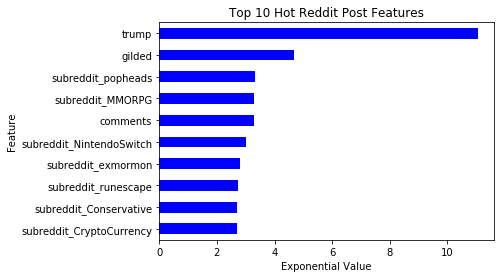

In [164]:
coef_features_top = coef_df.sort_values("exponential_value", ascending=False).head(10)

coef_features_top = coef_features_top.sort_values("exponential_value", ascending=True)

coef_features_top.plot(kind="barh", x = "feature", y = "exponential_value", legend=False, color="blue")

plt.title("Top 10 Hot Reddit Post Features")
plt.xlabel("Exponential Value")
plt.ylabel("Feature")

In [172]:
coef_features_bottom = coef_df.sort_values("exponential_value", ascending=False).tail(10)
coef_features_bottom;

Text(0,0.5,'Feature')

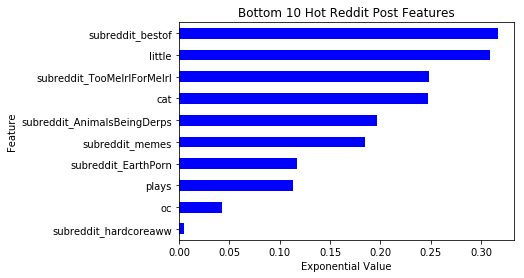

In [165]:
coef_features_bottom = coef_df.sort_values("exponential_value", ascending=False).tail(10)

coef_features_bottom = coef_features_bottom.sort_values("exponential_value", ascending=True)

coef_features_bottom.plot(kind="barh", x = "feature", y = "exponential_value", legend=False, color="blue")

plt.title("Bottom 10 Hot Reddit Post Features")
plt.xlabel("Exponential Value")
plt.ylabel("Feature")

## Predicting comments using Random Forests + Another Classifier

#### Thought experiment: What is the baseline accuracy for this model?

The baseline accuracy for this model is 50%. If we are using the median to build a binary classifier, before even examing the data, we are assuming half of the posts have above the median number of comments, and half of the posts have below the median number of comments.

### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [55]:
# Random Forest with just subreddits as features

subreddit_list_features = pd.get_dummies(data = scrape_1_df["subreddit"], drop_first = True, prefix="subreddit").columns

X = scrape_concated[subreddit_list_features]
y = scrape_concated["above_median_comments"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.6384

### Decision Tree with just subreddits as features


In [56]:
subreddit_list_features = pd.get_dummies(data = scrape_1_df["subreddit"], drop_first = True, prefix="subreddit").columns

X = scrape_concated[subreddit_list_features]
y = scrape_concated["above_median_comments"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

tree.score(X_test, y_test)

0.6064

### Random Forest with all features (subreddits and numeric) tested with cross validation score

In [57]:
features = [col for col in scrape_concated.columns if col not in ["above_median_comments", "num_comments"]]

X = scrape_concated[features]
y = scrape_concated["above_median_comments"]

cross_score = cross_val_score(rf, X, y, n_jobs = -1).mean()

cross_score

0.665192215975119

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

### Random Forest with all features (subreddits and numeric)

In [58]:
features = [col for col in scrape_concated.columns if col not in ["above_median_comments", "num_comments"]]

X = scrape_concated[features]
y = scrape_concated["above_median_comments"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

gs_params = {
    "n_estimators": [8, 9, 10, 11, 12],
    "min_samples_split": [2, 3, 4, 5, 6],
    "max_depth": [1, 2, 3, 4, 5]
}

lr_gridsearch = GridSearchCV(RandomForestClassifier(), gs_params)

lr_gridsearch_model = lr_gridsearch.fit(X_train, y_train)

best_score = (lr_gridsearch_model.best_score_)

best_params = (lr_gridsearch_model.best_params_)

best_score, best_params

(0.7450666666666667,
 {'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 8})

### Decision Tree with all features (subreddits and numeric)

In [59]:
features = [col for col in scrape_concated.columns if col not in ["above_median_comments", "num_comments"]]

X = scrape_concated[features]
y = scrape_concated["above_median_comments"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

gs_params = {
    "max_depth": [1, 2, 3, 4, 5],
    "min_samples_split": [2, 3, 4, 5, 6],
    "min_samples_leaf": [1, 2, 3, 4, 5]
}

lr_gridsearch = GridSearchCV(DecisionTreeClassifier(), gs_params)

lr_gridsearch_model = lr_gridsearch.fit(X_train, y_train)

best_score = (lr_gridsearch_model.best_score_)

best_params = (lr_gridsearch_model.best_params_)

best_score, best_params

(0.7498666666666667,
 {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2})

# Executive Summary

Comments can help to predict a Hot post, however, it appears that Reddit determines a Hot post by numerous factors including Subreddit, Upvotes, and Score (likely among many others) <br>

In order for a post to become Hot, the post must quickly gain popularity in its Subreddit and with luck “snowball” onto the home page in Popular and All <br>

The home page offers “the hottest of the Hot” from many different Subreddits <br>

Engaging, high quality, genuine/unique, and relevant content rises regardless of Subreddit, and having Subreddit members actively “scoring” New posts absolutely helps <br>

Reddit is for the people, by the people: it is very unlikely to “game the system” and create a Hot post <br>